# Loading Data

<h4>For this first part, the biggest challenge was to understand the provided code, since I basically just used Mariel's functions.load_data script modifying the default path to work in my folder hierarchy.<br><br>This code is super useful because it loads data, puts everything in a very handable data structure and format, pre-processes the joint positions so that they belong to the same unit cube (we are interested in relative motion instead of absolute motion), and computes the edges.</h4>

In [1]:
import torch
from torch_geometric.data import Data
import numpy as np
from glob import glob
import os

In [2]:
point_labels = ['ARIEL','C7','CLAV','LANK','LBHD','LBSH','LBWT','LELB','LFHD','LFRM','LFSH','LFWT','LHEL','LIEL','LIHAND','LIWR','LKNE','LKNI','LMT1','LMT5','LOHAND','LOWR','LSHN','LTHI','LTOE','LUPA','MBWT','MFWT','RANK','RBHD','RBSH','RBWT','RELB','RFHD','RFRM','RFSH','RFWT','RHEL','RIEL','RIHAND','RIWR','RKNE','RKNI','RMT1','RMT5','ROHAND','ROWR','RSHN','RTHI','RTOE','RUPA','STRN','T10']

reduced_joint_names = ['ARIEL','CLAV','RFSH','LFSH','RIEL','LIEL','RIWR','LIWR','RKNE','LKNE','RTOE','LTOE','LHEL','RHEL','RFWT','LFWT','LBWT','RBWT']

skeleton_lines = [
#     ( (start group), (end group) ),
    (('LHEL',), ('LTOE',)), # toe to heel
    (('RHEL',), ('RTOE',)),
    (('LMT1',), ('LMT5',)), # horizontal line across foot
    (('RMT1',), ('RMT5',)),   
    (('LHEL',), ('LMT1',)), # heel to sides of feet
    (('LHEL',), ('LMT5',)),
    (('RHEL',), ('RMT1',)),
    (('RHEL',), ('RMT5',)),
    (('LTOE',), ('LMT1',)), # toe to sides of feet
    (('LTOE',), ('LMT5',)),
    (('RTOE',), ('RMT1',)),
    (('RTOE',), ('RMT5',)),
    (('LKNE',), ('LHEL',)), # heel to knee
    (('RKNE',), ('RHEL',)),
    (('LFWT',), ('RBWT',)), # connect pelvis
    (('RFWT',), ('LBWT',)), 
    (('LFWT',), ('RFWT',)), 
    (('LBWT',), ('RBWT',)),
    (('LFWT',), ('LBWT',)), 
    (('RFWT',), ('RBWT',)), 
    (('LFWT',), ('LTHI',)), # pelvis to thighs
    (('RFWT',), ('RTHI',)), 
    (('LBWT',), ('LTHI',)), 
    (('RBWT',), ('RTHI',)), 
    (('LKNE',), ('LTHI',)), 
    (('RKNE',), ('RTHI',)), 
    (('CLAV',), ('LFSH',)), # clavicle to shoulders
    (('CLAV',), ('RFSH',)), 
    (('STRN',), ('LFSH',)), # sternum & T10 (back sternum) to shoulders
    (('STRN',), ('RFSH',)), 
    (('T10',), ('LFSH',)), 
    (('T10',), ('RFSH',)), 
    (('C7',), ('LBSH',)), # back clavicle to back shoulders
    (('C7',), ('RBSH',)), 
    (('LFSH',), ('LBSH',)), # front shoulders to back shoulders
    (('RFSH',), ('RBSH',)), 
    (('LFSH',), ('RBSH',)),
    (('RFSH',), ('LBSH',)),
    (('LFSH',), ('LUPA',),), # shoulders to upper arms
    (('RFSH',), ('RUPA',),), 
    (('LBSH',), ('LUPA',),), 
    (('RBSH',), ('RUPA',),), 
    (('LIWR',), ('LIHAND',),), # wrist to hand
    (('RIWR',), ('RIHAND',),),
    (('LOWR',), ('LOHAND',),), 
    (('ROWR',), ('ROHAND',),),
    (('LIWR',), ('LOWR',),), # across the wrist 
    (('RIWR',), ('ROWR',),), 
    (('LIHAND',), ('LOHAND',),), # across the palm 
    (('RIHAND',), ('ROHAND',),), 
    (('LFHD',), ('LBHD',)), # draw lines around circumference of the head
    (('LBHD',), ('RBHD',)),
    (('RBHD',), ('RFHD',)),
    (('RFHD',), ('LFHD',)),
    (('LFHD',), ('ARIEL',)), # connect circumference points to top of head
    (('LBHD',), ('ARIEL',)),
    (('RBHD',), ('ARIEL',)),
    (('RFHD',), ('ARIEL',)),
]

In [3]:
class MarielDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, reduced_joints=False, xy_centering=True, seq_len=128, predicted_timesteps=1, file_path="../data/mariel_*.npy", no_overlap=False):
        'Initialization'
        self.file_path      = file_path
        self.seq_len        = seq_len
        self.no_overlap     = no_overlap
        self.reduced_joints = reduced_joints # use a meaningful subset of joints
        self.data           = load_data(pattern=file_path) 
        self.xy_centering   = xy_centering
        self.n_joints       = 53
        self.n_dim          = 6
        self.predicted_timesteps = predicted_timesteps
        
        print("")
        
        if self.no_overlap == True:
            print("Generating non-overlapping sequences...")   
        else:
            print("Generating overlapping sequences...")
        
        if self.xy_centering == True: 
            print("Using (x,y)-centering...")
        else: 
            print("Not using (x,y)-centering...")
            
        if self.reduced_joints == True: 
            print("Reducing joints...")
        else:
            print("Using all joints...")

    def __len__(self):
        'Denotes the total number of samples'
        if self.xy_centering: 
            data = self.data[1] # choose index 1, for the (x,y)-centered phrases
        else: 
            data = self.data[0] # choose index 0, for data without (x,y)-centering
        
        if self.no_overlap == True:
             # number of complete non-overlapping phrases
            return int(len(data)/self.seq_len)
        else:
            # number of overlapping phrases up until the final complete phrase
            return len(data)-self.seq_len 

    def __getitem__(self, index):
        'Generates one sample of data'  
        edge_index, is_skeleton_edge, reduced_joint_indices = edges(reduced_joints=self.reduced_joints, seq_len=self.seq_len)
            
        if self.xy_centering == True: 
            data = self.data[1] # choose index 1, for the (x,y)-centered phrases
        else: 
            data = self.data[0] # choose index 0, for data without (x,y)-centering

        if self.reduced_joints == True: 
            data = data[:,reduced_joint_indices,:] # reduce number of joints if desired
            
        if self.no_overlap == True:  
            # non-overlapping phrases
            index = index*self.seq_len
            sequence = data[index:index+self.seq_len]
            prediction_target = data[index:index+self.seq_len+self.predicted_timesteps]
        else: 
            # overlapping phrases
            sequence = data[index:index+self.seq_len]
            prediction_target = data[index:index+self.seq_len+self.predicted_timesteps]

        sequence = np.transpose(sequence, [1,0,2]) # put n_joints first
        sequence = sequence.reshape((data.shape[1],self.n_dim*self.seq_len)) # flatten n_dim*seq_len into one dimension (i.e. node feature)
        prediction_target = np.transpose(prediction_target, [1,0,2]) # put n_joints first
        prediction_target = prediction_target.reshape((data.shape[1],self.n_dim*(self.seq_len+self.predicted_timesteps))) 

        # Convert to torch objects
        sequence = torch.Tensor(sequence)
        prediction_target = torch.Tensor(prediction_target)
        edge_attr = torch.Tensor(is_skeleton_edge)
        
        return Data(x=sequence, y=prediction_target, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr)

def load_data(pattern="../data/mariel_*.npy"):
   # load up the six datasets, performing some minimal preprocessing beforehand
    datasets = {}
    ds_all = []
    
    exclude_points = [26,53]
    point_mask = np.ones(55, dtype=bool)
    point_mask[exclude_points] = 0
    
    for f in sorted(glob(pattern)):
        ds_name = os.path.basename(f)[7:-4]
        ds = np.load(f).transpose((1,0,2))
        ds = ds[500:-500, point_mask]
        ds[:,:,2] *= -1
        datasets[ds_name] = ds
        ds_all.append(ds)

    ds_counts = np.array([ds.shape[0] for ds in ds_all])
    ds_offsets = np.zeros_like(ds_counts)
    ds_offsets[1:] = np.cumsum(ds_counts[:-1])

    ds_all = np.concatenate(ds_all)
    print("Original numpy dataset contains {:,} timesteps of {} joints with {} dimensions each.".format(ds_all.shape[0], ds_all.shape[1], ds_all.shape[2]))

    low,hi = np.quantile(ds_all, [0.01,0.99], axis=(0,1))
    xy_min = min(low[:2])
    xy_max = max(hi[:2])
    xy_range = xy_max-xy_min
    ds_all[:,:,:2] -= xy_min
    ds_all *= 2/xy_range
    ds_all[:,:,:2] -= 1.0

    ### It's also useful to have these datasets centered, i.e. with the x and y offsets subtracted from each individual frame:
    ds_all_centered = ds_all.copy()
    ds_all_centered[:,:,:2] -= ds_all_centered[:,:,:2].mean(axis=1,keepdims=True)

    datasets_centered = {}
    for ds in datasets:
        datasets[ds][:,:,:2] -= xy_min
        datasets[ds] *= 2/xy_range
        datasets[ds][:,:,:2] -= 1.0
        datasets_centered[ds] = datasets[ds].copy()
        datasets_centered[ds][:,:,:2] -= datasets[ds][:,:,:2].mean(axis=1,keepdims=True)
    
    ### Calculate velocities (first velocity is always 0)
    velocities = np.vstack([np.zeros((1,53,3)),np.array([35*(ds_all[t+1,:,:] - ds_all[t,:,:]) for t in range(len(ds_all)-1)])]) # (delta_x/y/z per frame) * (35 frames/sec)
    
    ### Stack positions above velocities
    ds_all = np.dstack([ds_all,velocities]) # stack along the 3rd dimension, i.e. "depth-wise"
    ds_all_centered = np.dstack([ds_all_centered,velocities]) # stack along the 3rd dimension, i.e. "depth-wise"

    for data in [ds_all, ds_all_centered]:
        # Normalize locations & velocities (separately) to [-1, 1]
        loc_min = np.min(data[:,:,:3])
        loc_max = np.max(data[:,:,:3])
        vel_min = np.min(data[:,:,3:])
        vel_max = np.max(data[:,:,3:])
        print("loc_min:",loc_min,"loc_max:",loc_max)
        print("vel_min:",vel_min,"vel_max:",vel_max)
        data[:,:,:3] = (data[:,:,:3] - loc_min) * 2 / (loc_max - loc_min) - 1
        data[:,:,3:] = (data[:,:,3:] - vel_min) * 2 / (vel_max - vel_min) - 1
    
    return ds_all, ds_all_centered, datasets, datasets_centered, ds_counts

def edges(reduced_joints, seq_len):
    ### Define a subset of joints if we want to train on fewer joints that still capture meaningful body movement:
    if reduced_joints == True:
        reduced_joint_indices = [point_labels.index(joint_name) for joint_name in reduced_joint_names]
        edge_index = np.array([(i,j) for i in reduced_joint_indices for j in reduced_joint_indices if i!=j])
    else:
        reduced_joint_indices = None
        edge_index = np.array([(i,j) for i in range(53) for j in range(53) if i!=j]) # note: no self-loops!

    skeleton_idxs = []
    for g1,g2 in skeleton_lines:
        entry = []
        entry.append([point_labels.index(l) for l in g1][0])
        entry.append([point_labels.index(l) for l in g2][0])
        skeleton_idxs.append(entry)
        
    is_skeleton_edge = []      
    for edge in np.arange(edge_index.shape[0]): 
        if [edge_index[edge][0],edge_index[edge][1]] in skeleton_idxs: 
            is_skeleton_edge.append(torch.tensor(1.0))
        else:
            is_skeleton_edge.append(torch.tensor(0.0))
    
    is_skeleton_edge = np.array(is_skeleton_edge)
    copies = np.tile(is_skeleton_edge, (seq_len,1)) # create copies of the 1D array for every timestep
    skeleton_edges_over_time = torch.tensor(np.transpose(copies))
    
    if reduced_joints == True: 
        ### Need to remake these lists to include only nodes 0-18 now
        edge_index = np.array([(i,j) for i in np.arange(len(reduced_joint_indices)) for j in np.arange(len(reduced_joint_indices)) if i!=j])
    
    return torch.tensor(edge_index, dtype=torch.long), skeleton_edges_over_time, reduced_joint_indices

# Visualizing Dance

<h4>This is the part I effectvely started developing, instantiating the MarielDataset class, experimenting for quite a while with the data to understand what each part actually represented, then building up a static visualization scheme to make sure everything was in order and finally generating the animation of a sequence.</h4>

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
%matplotlib inline
from IPython.display import HTML

# ffmpeg_path='/home/lui/anaconda3/envs/ai_choreo/bin/ffmpeg'
# plt.rcParams['animation.ffmpeg_path'] = ffmpeg_path

In [ ]:
dancer_data = MarielDataset(reduced_joints=False)

In [23]:
chosen_segment = 3500
n_joints = len(reduced_joint_names) if dancer_data.reduced_joints else dancer_data.n_joints
joint_positions = dancer_data[chosen_segment].x.view(n_joints, -1, 6)[:, :, :3].numpy()
edge_indexes = dancer_data[chosen_segment].edge_index.numpy()
edge_attributes = dancer_data[chosen_segment].edge_attr.numpy()

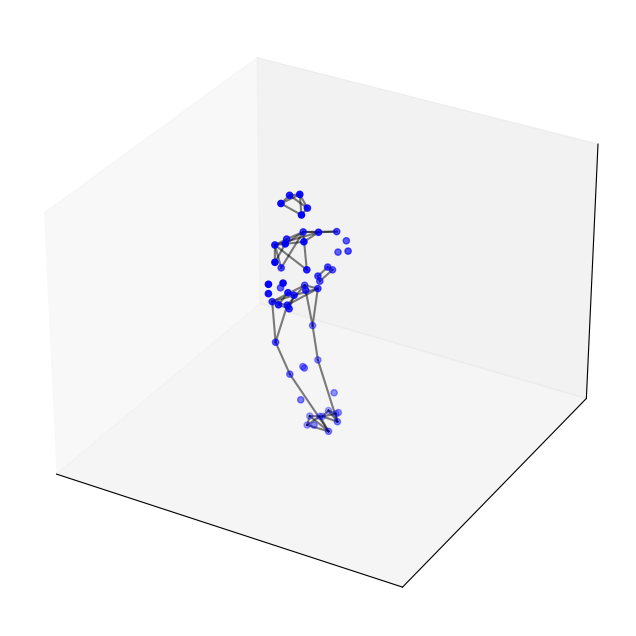

In [24]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.set_xlim3d(-1, 0.5)
ax.set_ylim3d(-1, 0.5)
ax.set_ylim3d(-1, 0.5)

ax.scatter(joint_positions[:, 0, 0], joint_positions[:, 0, 1], joint_positions[:, 0, 2], color='b')

active_edges = np.where(edge_attributes.transpose()[0] == 1)
for start_joint, end_joint in edge_indexes.transpose()[active_edges]:
    x = [joint_positions[start_joint][0, 0], joint_positions[end_joint][0, 0]]
    y = [joint_positions[start_joint][0, 1], joint_positions[end_joint][0, 1]]
    z = [joint_positions[start_joint][0, 2], joint_positions[end_joint][0, 2]]
    ax.plot(x, y, z, color='black', alpha=0.5)

In [25]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.set_xlim3d(-1, 0.5)
ax.set_ylim3d(-1, 0.5)
ax.set_ylim3d(-1, 0.5)

points = [ax.plot(joint_position[0, 0], joint_position[0, 1], \
                  joint_position[0, 2], 'o', color='b')[0] for joint_position in joint_positions]
edge_lines = []

def update(num, joint_positions, points, ax, edge_indexes, edge_attributes, edge_lines):
    for joint_position, point in zip(joint_positions, points):
        new_x, new_y = joint_position[num, :2].tolist()
        point.set_data(new_x, new_y)
        point.set_3d_properties(joint_position[num, 2])

    for line in edge_lines:
        line.remove()
    edge_lines.clear()

    active_edges = np.where(edge_attributes.transpose()[num] == 1)
    for start_joint, end_joint in edge_indexes.transpose()[active_edges]:
        x = [joint_positions[start_joint][num, 0], joint_positions[end_joint][num, 0]]
        y = [joint_positions[start_joint][num, 1], joint_positions[end_joint][num, 1]]
        z = [joint_positions[start_joint][num, 2], joint_positions[end_joint][num, 2]]
        edge_line = ax.plot(x, y, z, color='black', alpha=0.5)[0]
        edge_lines.append(edge_line)


animation = FuncAnimation(fig, update, frames=joint_positions.shape[1], fargs=(joint_positions, points, ax, \
                                                          edge_indexes, edge_attributes, edge_lines), interval=50)

plt.close(fig)

HTML(animation.to_jshtml())

/tmp/ipykernel_23912/2000272425.py:21: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(new_x, new_y)
